# [Volatility model calibration with neural networks a comparison between direct and indirect methods](https://arxiv.org/abs/2007.03494)

In a recent paper "[Deep Learning Volatilities](https://arxiv.org/abs/1901.09647)" a fast 2-step deep calibration algorithm for rough volatility models was proposed: in the first step the time consuming mapping from the model parameter to the implied volatilities is learned by a  neural network and in the second step standard solver techniques are used to find the  best model parameter.

In our paper we compare these results with an alternative direct approach where the the mapping from market implied volatilities to model parameters is  approximated by the neural network, without the  need for an extra solver step. Using a whitening procedure and a projection of the target parameter to [0,1], in order to be able to use  a sigmoid type output function we found that the direct approach outperforms the two-step one  for the data sets and methods published in. 

For our implementation we use  the  open source tensorflow 2 library with python 3.7.3 and the packages given in *requirements.python373.pip.txt*. 

Authors: Dirk Roeder and Georgi Dimitroff

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import numpy as np
import datetime
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

First define a dictionary with the properties of the data sets.

In [2]:
volatility_model_def={}
volatility_model_def['Heston']={}
volatility_model_def['Heston']['volatility_model']='Heston'
volatility_model_def['Heston']['parameter_names']=["$\\xi_0$","$\\rho$","$\\sigma$","$\\theta$", "$\\kappa$"]
volatility_model_def['Heston']['parameter_lower_bounds']=[0.0001,-0.95,0.01,0.01,1]
volatility_model_def['Heston']['parameter_upper_bounds']=[0.04,-0.1,1.0,0.2,10.0]
volatility_model_def['Heston']['n_test_train']=[1800, 10200]    

volatility_model_def['RoughBergomiPiecewiseForwardVariance']={}
volatility_model_def['RoughBergomiPiecewiseForwardVariance']['volatility_model']='RoughBergomiPiecewiseForwardVariance'
volatility_model_def['RoughBergomiPiecewiseForwardVariance']['parameter_names']=["$\\xi_1$","$\\xi_2$","$\\xi_3$","$\\xi_4$","$\\xi_5$","$\\xi_6$","$\\xi_7$","$\\xi_8$","$\\nu$","$\\rho$","$H$"]
volatility_model_def['RoughBergomiPiecewiseForwardVariance']['parameter_lower_bounds']=[0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.5,-1,0.025]
volatility_model_def['RoughBergomiPiecewiseForwardVariance']['parameter_upper_bounds']=[0.16,0.16,0.16,0.16,0.16,0.16,0.16,0.16,4,0,0.5]
volatility_model_def['RoughBergomiPiecewiseForwardVariance']['n_test_train']=[12000, 68000]
                                                        
volatility_model_def['RoughBergomiFlatForwardVariance']={}
volatility_model_def['RoughBergomiFlatForwardVariance']['volatility_model']='RoughBergomiFlatForwardVariance'
volatility_model_def['RoughBergomiFlatForwardVariance']['parameter_names']=["$\\xi_0$","$\\nu$","$\\rho$","$H$"]
volatility_model_def['RoughBergomiFlatForwardVariance']['parameter_lower_bounds']=[0.01,0.3,-0.95,0.025]
volatility_model_def['RoughBergomiFlatForwardVariance']['parameter_upper_bounds']=[0.16,4,-0.1,0.5]
volatility_model_def['RoughBergomiFlatForwardVariance']['n_test_train']=[6000, 34000]    
                                                   
volatility_model_def['1FactorFlatForwardVariance']={}
volatility_model_def['1FactorFlatForwardVariance']['volatility_model']='1FactorFlatForwardVariance'
volatility_model_def['1FactorFlatForwardVariance']['parameter_names']=["$\\xi_0$","$\\nu$","$\\beta$","$\\rho$"]
volatility_model_def['1FactorFlatForwardVariance']['parameter_lower_bounds']=[0.01,0.5,0,-1]
volatility_model_def['1FactorFlatForwardVariance']['parameter_upper_bounds']=[0.16,4,10,0]
volatility_model_def['1FactorFlatForwardVariance']['n_test_train']=[6000, 34000]        
                                                   
volatility_model_def['1FactorPiecewiseForwardVariance']={}
volatility_model_def['1FactorPiecewiseForwardVariance']['volatility_model']='1FactorPiecewiseForwardVariance'
volatility_model_def['1FactorPiecewiseForwardVariance']['parameter_names']=["$\\xi_1$","$\\xi_2$","$\\xi_3$","$\\xi_4$","$\\xi_5$","$\\xi_6$","$\\xi_7$","$\\xi_8$","$\\nu$","$\\beta$","$\\rho$"]
volatility_model_def['1FactorPiecewiseForwardVariance']['parameter_lower_bounds']=[0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.5,0.0,-0.95]    
volatility_model_def['1FactorPiecewiseForwardVariance']['parameter_upper_bounds']=[0.16,0.16,0.16,0.16,0.16,0.16,0.16,0.16,4,10,-0.1]
volatility_model_def['1FactorPiecewiseForwardVariance']['n_test_train']=[12000, 68000]   


Define some helper functions for ploting, loading and scaling the data.

In [3]:
def plot_parameter(parameter, parameter_prediction, filename, title, save_plot=False):
    """Plot target and predicted parameter and save image.

    Input:
    -parameter (Pandas.DataFrame): target parameter
    -parameter_prediction (Pandas.DataFrame): predicted parameter
    -filename (string): filename image
    -title(string): image title
    -save_plot (bool): save or save not
    
    Output:
    If save_plot is True the figure is saved in the images directory.
    """    
    summary={}
    parameter_names=parameter['train'].columns
    for data_type in ('train', 'test'):
        summary[data_type]=parameter_prediction[data_type].copy()
        summary[data_type].columns=[x+'-prediction' for x in parameter_names]
        summary[data_type]=pd.concat([parameter[data_type], summary[data_type]], axis=1)
        for parameter_name in parameter_names:
            summary[data_type][parameter_name+'_diff']=summary[data_type][parameter_name+'-prediction']\
            -summary[data_type][parameter_name]

    fig, axs = plt.subplots(len(parameter_names),4, figsize=(15,20))
    for i_parameter, parameter_name in enumerate(parameter_names):   
        if i_parameter == 0:
            summary['train'].plot.scatter(x=parameter_name,y=parameter_name+'-prediction',\
                title='train', ax=axs[i_parameter,0])
            summary['train'][parameter_name+'_diff'].plot.hist(bins=20,\
                title='train density reconstruction errors',\
                ax=axs[i_parameter,1], density=True)
            summary['test'].plot.scatter(x=parameter_name,y=parameter_name+'-prediction',\
                title='test', ax=axs[i_parameter,2])
            summary['test'][parameter_name+'_diff'].plot.hist(bins=20,\
                title='test density reconstruction errors',\
                ax=axs[i_parameter,3], density=True)    
        else:
            summary['train'].plot.scatter(x=parameter_name,y=parameter_name+'-prediction',\
                ax=axs[i_parameter,0])
            summary['train'][parameter_name+'_diff'].plot.hist(bins=20,\
                ax=axs[i_parameter,1], density=True)
            summary['test'].plot.scatter(x=parameter_name,y=parameter_name+'-prediction',\
                ax=axs[i_parameter,2])
            summary['test'][parameter_name+'_diff'].plot.hist(bins=20,\
                ax=axs[i_parameter,3], density=True)    
        
    st = fig.suptitle(title, fontsize="x-large")    
    fig.tight_layout()

    st.set_y(0.95)
    fig.subplots_adjust(top=0.9)
    if save_plot:
        fig.savefig(os.path.join('images',filename+'.png'), dpi=100)
    
    plt.show()
    return summary

def load_data_from_csv(id_volatility_model, volatility_model_def):
    """Load data from csv into Dataframe.

    Input:
    -id_volatility_model (string): id of volatility model
    -volatility_model_def (dict): number of train-test datasets
    
    Output:
    -volatilities, parameter (Pandas.DataFrame): Dataframe contains data samples
    """
    volatility_model=volatility_model_def[id_volatility_model]['volatility_model']
    n_test_train=volatility_model_def[id_volatility_model]['n_test_train']
    
    volatilities={}
    volatilities['test']=pd.read_csv(os.path.join('data',volatility_model+'_volatilities_test_'+str(n_test_train[0])+'.csv.gz'), sep=',', compression='gzip')
    volatilities['train']=pd.read_csv(os.path.join('data',volatility_model+'_volatilities_train_'+str(n_test_train[1])+'.csv.gz'), sep=',', compression='gzip')

    parameter={}
    parameter['test']=pd.read_csv(os.path.join('data',volatility_model+'_parameter_test_'+str(n_test_train[0])+'.csv.gz'), sep=',', compression='gzip')
    parameter['train']=pd.read_csv(os.path.join('data',volatility_model+'_parameter_train_'+str(n_test_train[1])+'.csv.gz'), sep=',', compression='gzip')
    
    return volatilities, parameter

def scale_to_0_1(volatility_model_parameter, id_volatility_model):    
    """Scale parameter from model parameter bounderies to [0, 1].

    Input:
    -volatility_model_parameter_recaled (dict): parameter on [0, 1] interval
    -id_volatility_model (string): id of volatility model
    -volatility_model_parameter (dict): parameter in model bounderies
    
    Output:
    -volatility_model_def (dict): number of train-test datasets
    """    
    parameter_lower_bounds=volatility_model_def[id_volatility_model]['parameter_lower_bounds']
    parameter_upper_bounds=volatility_model_def[id_volatility_model]['parameter_upper_bounds']
    parameter_names=volatility_model_def[id_volatility_model]['parameter_names']
    volatility_model_parameter_recaled=volatility_model_parameter.copy()
    for i_parameter, parameter_name in enumerate(parameter_names):
        volatility_model_parameter_recaled[parameter_name]=(volatility_model_parameter[parameter_name]\
        -parameter_lower_bounds[i_parameter])/(parameter_upper_bounds[i_parameter]\
        -parameter_lower_bounds[i_parameter])
    return volatility_model_parameter_recaled

def rescale_from_0_1(volatility_model_parameter_recaled, id_volatility_model, volatility_model_def):
    """Rescale parameter from [0, 1] to model parameter bounderies.

    Input:
    -volatility_model_parameter_recaled (dict): parameter on [0, 1] interval
    -id_volatility_model (string): id of volatility model
    -volatility_model_def (dict): number of train-test datasets
    
    Output:
    -volatility_model_parameter (dict): parameter in model bounderies
    """
    parameter_lower_bounds=volatility_model_def[id_volatility_model]['parameter_lower_bounds']
    parameter_upper_bounds=volatility_model_def[id_volatility_model]['parameter_upper_bounds']
    parameter_names=volatility_model_def[id_volatility_model]['parameter_names']
    volatility_model_parameter=volatility_model_parameter_recaled.copy()
    for i_parameter, parameter_name in enumerate(parameter_names):
        volatility_model_parameter[parameter_name]=volatility_model_parameter_recaled[parameter_name]*\
        (parameter_upper_bounds[i_parameter]-parameter_lower_bounds[i_parameter])\
        +parameter_lower_bounds[i_parameter]
    return volatility_model_parameter

The ZCA whittening function. 

In [4]:
def zca_whiten(X):
    """
    Applies ZCA whitening to the data (X) Data ,
    
    X^T * X = CovX = U *d* U^T where the columns of E are the normalized eigenvectors
    D=d^(-1/2), the whitening matrix is W = E * D * E^T: Xw = X*W
    Cov Xw = Xw^T*Xw = E*D*E^T*X^T*X*E*D*E^T = E*D*E^T*CovX*E*D*E^T = E*D*E^T*E *d* E^T*E*D*E^T = I
    The inverse is W^-1: W^-1 = E * D^(-1) * E^T
    The un-whitened matrix is X = (X*W)*W^-1

    Input:
    -X (numpy array): input data, rows are data points, columns are features
    
    Output:
    -X_mean (array): mean of X
    -W (matrix): dewhitening matrix
    """

    EPS = 10e-18
    upperBound=10e14
    meanX = np.mean(X, axis=0)
    Xc = X - meanX

    cov = np.dot(Xc.T, X)/float(Xc.shape[0]-1.0)

    U,d, _ = np.linalg.svd(cov)
    d = np.sqrt(np.clip(a=d, a_min=EPS, a_max=upperBound))
    D_whiten = np.diag(1. / d)
    D_dewhiten = np.diag(d)    
    W = np.dot(np.dot(U, D_whiten), U.T)
    W_dewhiten = np.dot(np.dot(U, D_dewhiten), U.T)
    X_white = np.dot(Xc, W)

    # test
    test1 = np.std(X_white, axis=0)
    test2 = np.add(np.dot(X_white, W_dewhiten),meanX)
    print("white reconstruction error: "+str(np.max( X-test2 )))
    print("white standardization error: " + str(np.max(test1 - np.ones(test1.shape))))
    
    return meanX, W

The calibration function.

In [5]:
def calibrate_stacked_nn(n_layers, n_epochs, input_train, target_train, input_val, target_val, model_name):    
    """The main neural network function. Construct, train and save the model.

    Input:
    -n_layers (int): number of hidden layer
    -n_epochs (int): maximal number of epochs
    -input_train, input_val (numpy arrays): input train (valuation) data 
    -target_train, target_val (numpy arrays): target train (valuation) data 
    
    Output:
    The trained model is saved in the saved_model directory.
    """  
    batch_size = 256
    n_input_size = input_train.shape[1]
    n_output_size = target_train.shape[1]
    n_samples = input_train.shape[0]
    STEPS_PER_EPOCH = int(n_samples/batch_size)
    print('STEPS_PER_EPOCH: ', STEPS_PER_EPOCH)

    model = keras.models.Sequential()
    model.add(layers.InputLayer(n_input_size))        
    step_size=(n_output_size-n_input_size)/(n_layers+1)
    for i in range(1,n_layers+1,1):
        n_neurons = int(n_input_size+i*step_size)
        model.add(layers.Dense(n_neurons, activation='selu',
                         kernel_initializer=keras.initializers.VarianceScaling(scale=1.0, mode='fan_in'),
                         bias_initializer=keras.initializers.zeros(),
                         kernel_regularizer=keras.regularizers.l2(0.000001)))   
    model.add(layers.Dense(n_output_size, activation='hard_sigmoid', name='output'))

    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      0.001, decay_steps=STEPS_PER_EPOCH*1000, decay_rate=1, staircase=False)
    optimizer = keras.optimizers.Adam(lr_schedule)
    loss = keras.losses.mean_squared_error
    
    model.compile(optimizer=optimizer, loss=loss)
    
    log_dir = os.path.join('tensorboard', model_name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, profile_batch=0)
    earlyStopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=500,\
                                        restore_best_weights=True)
    
    #print(model.summary())
    model.fit(x=input_train, y=target_train, \
        batch_size=batch_size, epochs=n_epochs,
        validation_data=[input_val, target_val], verbose=1,\
        callbacks=[tensorboard_callback, earlyStopping_callback])
    model.save(os.path.join('saved_model', model_name+'.h5'), save_format='h5')
    


If *calibrate_nn_model* is set to False, the trained model is taken from the *saved_model* directory, the prediction are calculated and the images are created. If *calibrate_nn_model* is set to True, aditionaly, the model is trained (depending on your computer this step needs a few hours).

In [ ]:
calibrate_nn_model=False
list_datasets=('1FactorFlatForwardVariance','1FactorPiecewiseForwardVariance','RoughBergomiPiecewiseForwardVariance','RoughBergomiFlatForwardVariance','Heston')
#list_datasets=('RoughBergomiPiecewiseForwardVariance',) #use this line if you want to performa a single dataset 
for id_volatility_model in list_datasets:
    print("id_volatility_model: ",id_volatility_model)
    volatilities, parameter = load_data_from_csv(id_volatility_model, volatility_model_def)                    

    X_mean, W = zca_whiten(volatilities['train'].values)
    volatilities_white={}
    volatilities_white['train']=pd.DataFrame(data=np.dot(volatilities['train'].values-X_mean,W),columns=volatilities['train'].columns)
    volatilities_white['test']=pd.DataFrame(data=np.dot(volatilities['test'].values-X_mean,W),columns=volatilities['train'].columns)

    n_epochs=50000
    n_layers=3
    model_name =volatility_model_def[id_volatility_model]['volatility_model']+'_volatilities_to_parameter_'+str(n_layers)+'selu'
    print('model_name: ', model_name)
    if calibrate_nn_model:
        calibrate_stacked_nn(n_layers=n_layers, n_epochs=n_epochs, \
            input_train=volatilities_white['train'].values,target_train=scale_to_0_1(parameter['train'], id_volatility_model).values,\
            input_val=volatilities_white['test'].values,target_val=scale_to_0_1(parameter['test'],id_volatility_model).values, \
            model_name=model_name)

    model = keras.models.load_model(os.path.join('saved_model',model_name+'.h5'))
    model.summary()

    parameter_prediction={}
    parameter_prediction['train']=pd.DataFrame(data=model.predict(volatilities_white['train']),columns=volatility_model_def[id_volatility_model]['parameter_names'])
    parameter_prediction['train']=rescale_from_0_1(parameter_prediction['train'], id_volatility_model, volatility_model_def)

    parameter_prediction['test']=pd.DataFrame(data=model.predict(volatilities_white['test']),columns=volatility_model_def[id_volatility_model]['parameter_names'])
    parameter_prediction['test']=rescale_from_0_1(parameter_prediction['test'], id_volatility_model, volatility_model_def)

    summary = plot_parameter(parameter, parameter_prediction, filename=model_name, title = 'Volatilities-2-Model - ' +id_volatility_model ,save_plot=True)

To show the effect of whittening. Plot the correlation before and after whittening.
First for the Rough Bergomi Model

In [7]:
id_volatility_model='RoughBergomiPiecewiseForwardVariance'
volatilities, parameter = load_data_from_csv(id_volatility_model, volatility_model_def)
X_mean, W = zca_whiten(volatilities['train'].values)
volatilities_white={}
volatilities_white['train']=pd.DataFrame(data=np.dot(volatilities['train'].values-X_mean,W),columns=volatilities['train'].columns)
volatilities_white['test']=pd.DataFrame(data=np.dot(volatilities['test'].values-X_mean,W),columns=volatilities['train'].columns)

white reconstruction error: 9.553469126899472e-14
white standardization error: -7.294875209118423e-06


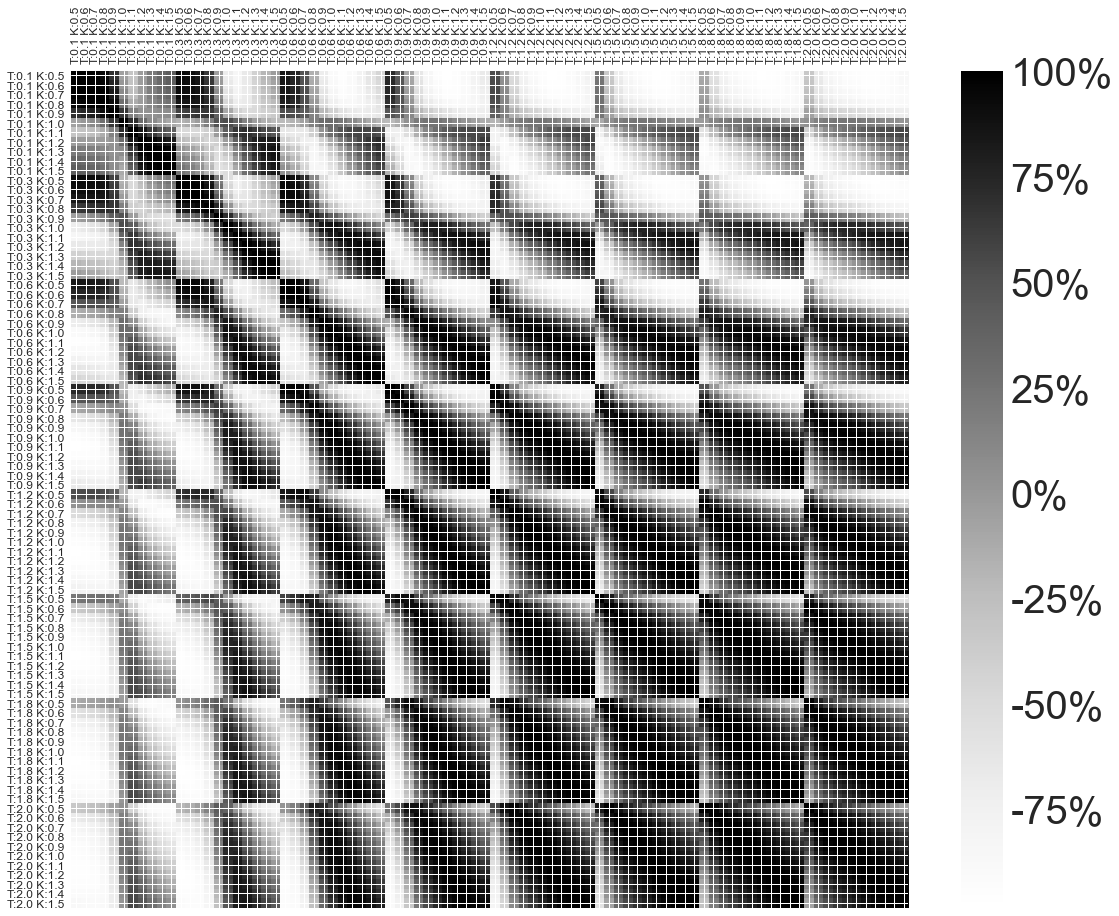

In [8]:
df=volatilities['train'].corr()
df.columns=[x.replace('volatility_','').replace('strike','K:').replace('maturity','T:').replace('_',' ') for x in df.columns]
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=12, rotation=90)
plt.yticks(range(df.shape[1]), df.columns, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=40)
cb.ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1))
f.savefig(os.path.join('images',id_volatility_model+'_COR.png'), dpi=100)

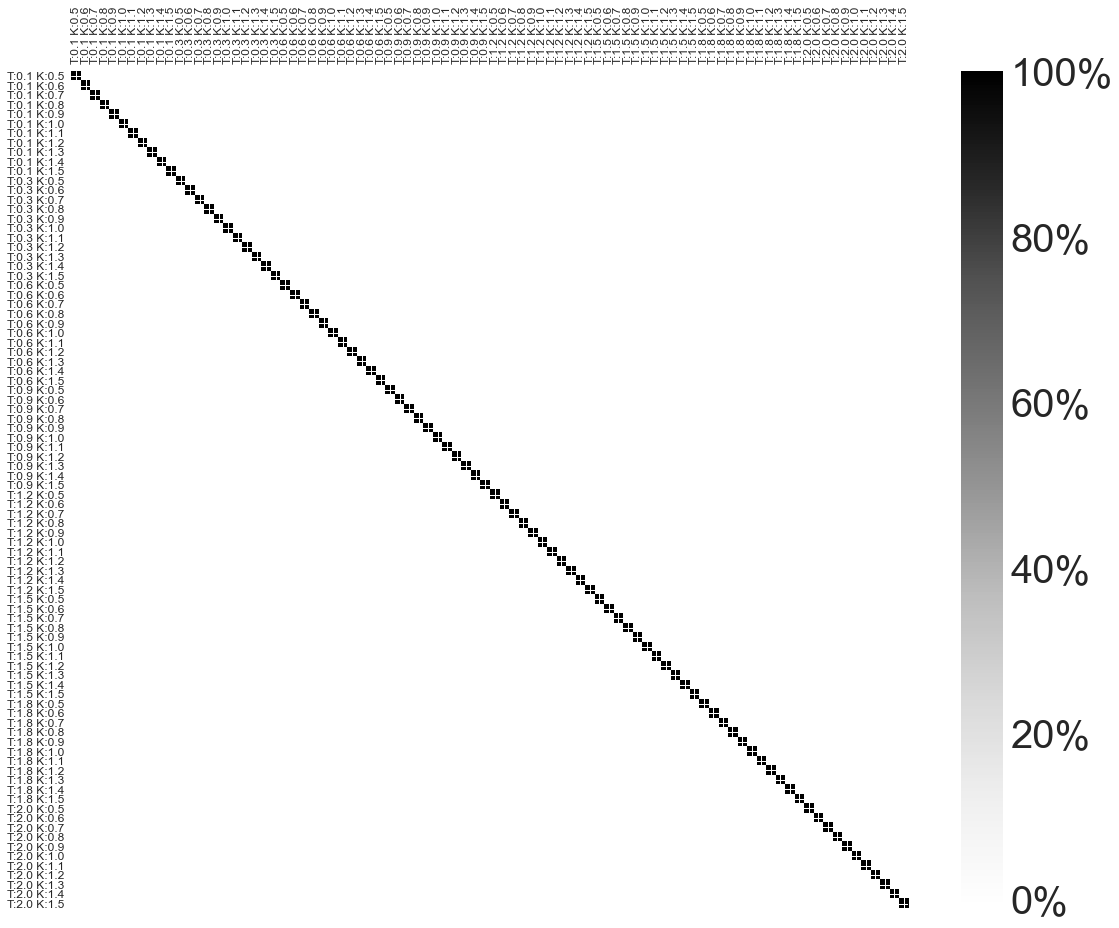

In [9]:
df=volatilities_white['train'].corr()
df.columns=[x.replace('volatility_','').replace('strike','K:').replace('maturity','T:').replace('_',' ') for x in df.columns]
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=12, rotation=90)
plt.yticks(range(df.shape[1]), df.columns, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=40)
cb.ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1))
f.savefig(os.path.join('images',id_volatility_model+'_white_COR.png'), dpi=100)

And for the heston dataset.

In [10]:
id_volatility_model='Heston'
volatilities, parameter = load_data_from_csv(id_volatility_model, volatility_model_def)
X_mean, W = zca_whiten(volatilities['train'].values)
volatilities_white={}
volatilities_white['train']=pd.DataFrame(data=np.dot(volatilities['train'].values-X_mean,W),columns=volatilities['train'].columns)
volatilities_white['test']=pd.DataFrame(data=np.dot(volatilities['test'].values-X_mean,W),columns=volatilities['train'].columns)

white reconstruction error: 5.16124143423724e-10
white standardization error: 0.1055779472232139


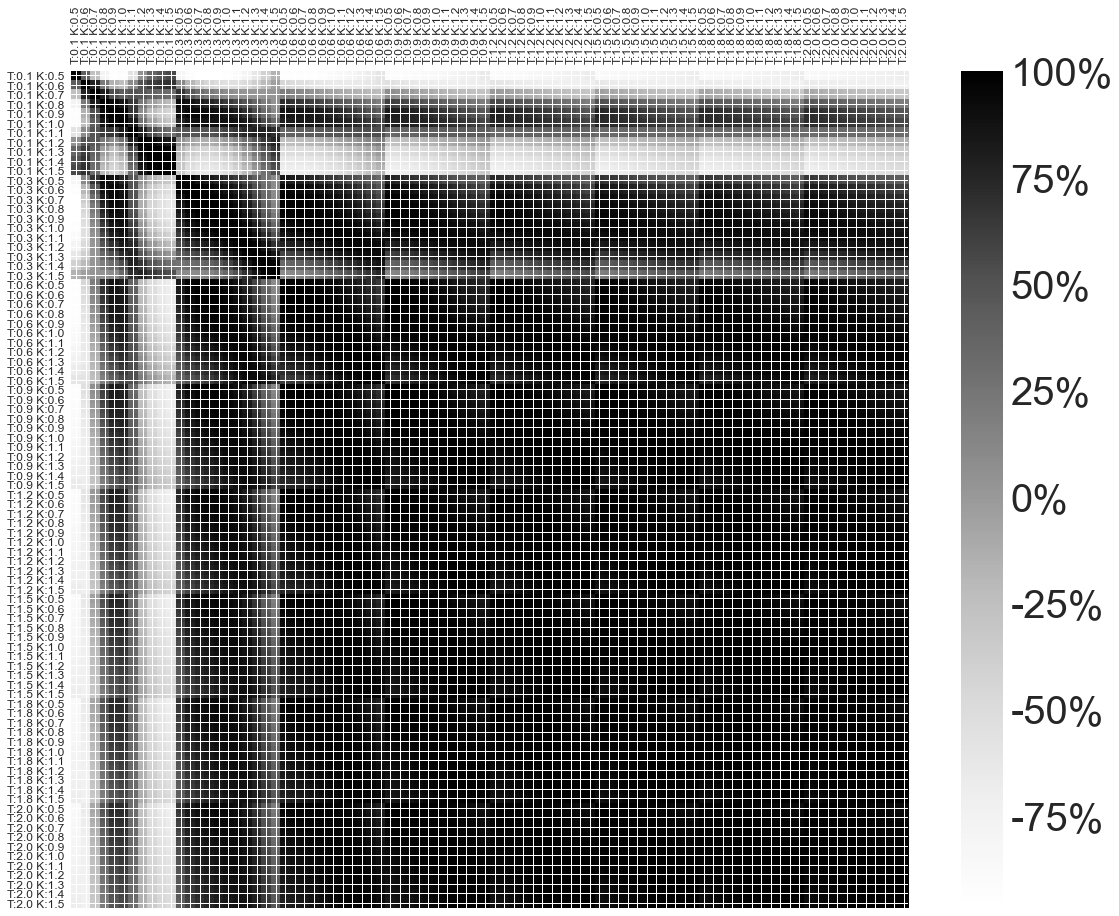

In [11]:
df=volatilities['train'].corr()
df.columns=[x.replace('volatility_','').replace('strike','K:').replace('maturity','T:').replace('_',' ') for x in df.columns]
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=12, rotation=90)
plt.yticks(range(df.shape[1]), df.columns, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=40)
cb.ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1))
f.savefig(os.path.join('images',id_volatility_model+'_COR.png'), dpi=100)

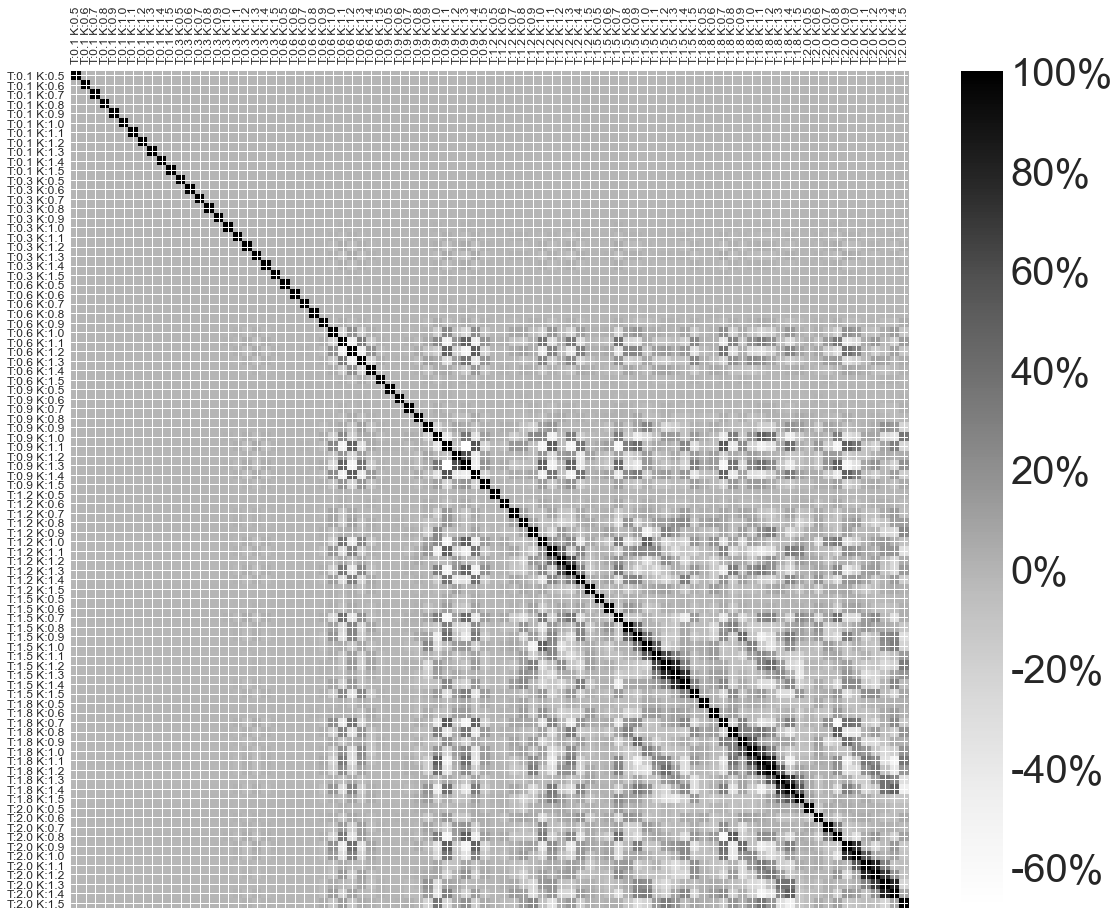

In [12]:
df=volatilities_white['train'].corr()
df.columns=[x.replace('volatility_','').replace('strike','K:').replace('maturity','T:').replace('_',' ') for x in df.columns]
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=12, rotation=90)
plt.yticks(range(df.shape[1]), df.columns, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=40)
cb.ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1))
f.savefig(os.path.join('images',id_volatility_model+'_white_COR.png'), dpi=100)